In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import json

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.utils import plot_model
import tensorflowjs as tfjs
from sklearn.preprocessing import MultiLabelBinarizer

from prepare_data import read_genres
from model import metalgen_model

In [9]:
core_genres = read_genres('data/core_genres.txt')
sub_genres = read_genres('data/sub_genres.txt')
print(core_genres, sub_genres)
any(sub in core_genres for sub in sub_genres)

['black', 'death', 'doom', 'grind', 'heavy', 'progressive', 'sludge', 'thrash'] ['melodic', 'technical', 'symphonic', 'brutal', 'blackened', 'atmospheric', 'stoner']


False

In [10]:
artists = pd.read_csv('data/metal_artists.csv').drop_duplicates()
artists.head()

name                        genre
0          0  Depressive Black/Doom Metal
1  0 X í S T         Blackened Doom Metal
2     0 Zone           Death/Thrash Metal
3    0% Hate        Technical Death Metal
4      0-Nun      Atmospheric Black Metal

In [11]:
all_genres = core_genres + sub_genres
with open('metalgen_genres.json', 'w') as genre_out:
    json.dump(all_genres, genre_out)

found = []
for genre in all_genres:
    found.append(
        artists['genre'].str.lower()
        .str.contains(genre)
    )
genre_table = pd.concat(found, axis=1)
genre_table.columns = all_genres
# Drop rows that don't match any of our main genres
genre_table = genre_table.loc[genre_table.any(axis=1), :]
artists = artists.loc[genre_table.index, :]
print(genre_table.shape)
genre_table.head()

(127857, 15)


black  death   doom  grind  heavy  progressive  sludge  thrash  melodic  \
0   True  False   True  False  False        False   False   False    False   
1   True  False   True  False  False        False   False   False    False   
2  False   True  False  False  False        False   False    True    False   
3  False   True  False  False  False        False   False   False    False   
4   True  False  False  False  False        False   False   False    False   

   technical  symphonic  brutal  blackened  atmospheric  stoner  
0      False      False   False      False        False   False  
1      False      False   False       True        False   False  
2      False      False   False      False        False   False  
3       True      False   False      False        False   False  
4      False      False   False      False         True   False

In [12]:
genre_table.sum(axis=0)

black          37382
death          46502
doom           11129
grind           5862
heavy          19252
progressive     9436
sludge          3846
thrash         27277
melodic        12118
technical       1984
symphonic       3224
brutal          4320
blackened       1081
atmospheric     2395
stoner          3771
dtype: int64

In [13]:
config = {
    'rnn_layers': 2,
    'rnn_size': 128,
    'rnn_bidirectional': False,
    'max_length': 40,
    'max_words': 10000,
    'dim_embeddings': 100,
    'word_level': False,
    'single_text': False
}
with open('metalgen_config.json', 'w') as json_out:
    json.dump(config, json_out)

In [14]:
from metalgen import MetalGen

In [15]:
metal_gen = MetalGen(context_size=genre_table.shape[1],
                     config_path='metalgen_config.json')
metal_gen.model.inputs

[<KerasTensor: shape=(None, 40) dtype=float32 (created by layer 'input')>,
 <KerasTensor: shape=(None, 15) dtype=float32 (created by layer 'context_input')>]

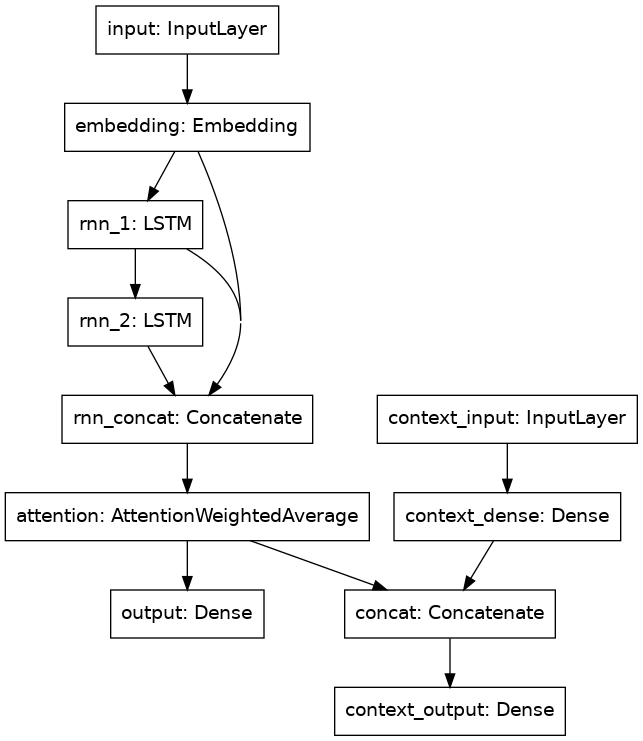

In [16]:
plot_model(metal_gen.model, to_file='metalgen.png')

In [17]:
metal_gen.config

{'rnn_layers': 2,
 'rnn_size': 128,
 'rnn_bidirectional': False,
 'max_length': 40,
 'max_words': 10000,
 'dim_embeddings': 100,
 'word_level': False,
 'single_text': False,
 'name': 'metalgen'}

In [18]:
metal_gen.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 100)      46500       input[0][0]                      
__________________________________________________________________________________________________
rnn_1 (LSTM)                    (None, 40, 128)      117248      embedding[0][0]                  
__________________________________________________________________________________________________
rnn_2 (LSTM)                    (None, 40, 128)      131584      rnn_1[0][0]                      
______________________________________________________________________________________________

In [19]:
for layer in metal_gen.model.layers:
    print(layer.name)
    print('=' * len(layer.name))
    for weight in layer.weights:
        print(weight.name)

input
=====
embedding
embedding/embeddings:0
rnn_1
=====
rnn_1/lstm_cell/kernel:0
rnn_1/lstm_cell/recurrent_kernel:0
rnn_1/lstm_cell/bias:0
rnn_2
=====
rnn_2/lstm_cell_1/kernel:0
rnn_2/lstm_cell_1/recurrent_kernel:0
rnn_2/lstm_cell_1/bias:0
rnn_concat
context_input
attention
attention/attention_W:0
context_dense
context_dense/kernel:0
context_dense/bias:0
concat
context_output
context_output/kernel:0
context_output/bias:0
output
output/kernel:0
output/bias:0


In [20]:
print(artists.shape, genre_table.shape)

(127857, 2) (127857, 15)


In [22]:
# If we want to just train on a subset
sample_artists = artists.sample(frac=0.1)['name']
sample_genres = genre_table.loc[sample_artists.index, :].to_numpy()
print(sample_artists.shape, sample_genres.shape)
sample_artists.head()

(12786,) (12786, 15)


75843     Magnus Karlsson's Free Fall
41658                        Elmesias
32766                         Decrypt
120722                     The Trauma
15674                      Black Rite
Name: name, dtype: object

In [23]:
metal_gen.train_on_texts(
    texts=artists['name'].values,
    context_labels=genre_table.to_numpy(),
    new_model=False,
    num_epochs=5,
    save_epochs=0,
    dropout=0.1,
    name='ma_full'
)

Training on 1,504,700 character sequences.


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

####################
Temperature: 0.2
####################
Servant Strange

Serpent Constrence

Sanguinal Sund

####################
Temperature: 0.5
####################
Serren Metally Mester

Sunda Doom

No Metall

####################
Temperature: 1.0
####################
Horn of Syris

Underwells

Rebless

####################
Temperature: 0.2
####################
Death Cross

Satanic Death

Satanic Prospence

####################
Temperature: 0.5
####################
Serpent Steel

Explosion

Malefic Morte

####################
Temperature: 1.0
####################
Bleeson

Mandort

Perfunnium

####################
Temperature: 0.2
####################
The Stone of the Storm

Death of Fire

Arcane Stone

####################
Temperature: 0.5
####################
Ventister

Orphenda

Crashing Silence

####################
Temperature: 1.0
####################
Anaticen

Buzzo

Death of Death

####################
Temperature: 0.2
####################
Death Serpent

Death Steel

Deat

In [24]:
tf.keras.backend.clear_session()

In [25]:
for layer in metal_gen.model.layers:
    print(layer.name)
    print('=' * len(layer.name))
    for weight in layer.weights:
        print(weight.name)

input
=====
embedding
embedding/embeddings:0
rnn_1
=====
rnn_1/lstm_cell/kernel:0
rnn_1/lstm_cell/recurrent_kernel:0
rnn_1/lstm_cell/bias:0
rnn_2
=====
rnn_2/lstm_cell_1/kernel:0
rnn_2/lstm_cell_1/recurrent_kernel:0
rnn_2/lstm_cell_1/bias:0
rnn_concat
context_input
attention
attention/attention_W:0
context_dense
context_dense/kernel:0
context_dense/bias:0
concat
context_output
context_output/kernel:0
context_output/bias:0
output
output/kernel:0
output/bias:0


In [26]:
metal_gen.model.save('export/metalgen_export.h5')

In [27]:
# Save in JS format
tfjs.converters.save_keras_model(metal_gen.model, 'export/js_model')

In [28]:
metal_gen.model.inputs

[<KerasTensor: shape=(None, 40) dtype=float32 (created by layer 'input')>,
 <KerasTensor: shape=(None, 15) dtype=float32 (created by layer 'context_input')>]

In [29]:
metal_gen.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 100)      46500       input[0][0]                      
__________________________________________________________________________________________________
rnn_1 (LSTM)                    (None, 40, 128)      117248      embedding[0][0]                  
__________________________________________________________________________________________________
rnn_2 (LSTM)                    (None, 40, 128)      131584      rnn_1[0][0]                      
______________________________________________________________________________________________

In [30]:
def make_input(genres):
    return np.array([[
        1 if g in genres else 0 
        for g in all_genres
    ]])

In [31]:
death_input = make_input(['death'])
black_input = make_input(['black'])
death_input

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [32]:
metal_gen.generate_from_context(death_input, n=3)

 33%|███▎      | 1/3 [00:00<00:01,  1.48it/s]

Gravestorm



 67%|██████▋   | 2/3 [00:00<00:00,  2.35it/s]

Under the Dead



100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

Realm of Exile



In [33]:
metal_gen.generate_from_context(black_input, n=3)

 33%|███▎      | 1/3 [00:00<00:00,  3.44it/s]

Endless Necrosis



100%|██████████| 3/3 [00:00<00:00,  3.70it/s]

Horror of the Blood

Unholy Sun



In [34]:
all_input = make_input(all_genres)
for temperature in [0.5, 0.75, 1.0]:
    metal_gen.generate_from_context(all_input, temperature=temperature, n=5, progress=False)

Hyperion

Armaged Souls

Soul Sin Moon

Endless Shadows

Black Still Conspirality

Delirious Scorn

Child of Sights

Otherian

Genetic Corpses

Oppisticide

Tarpar Ragh

Acid Bleeding

Bloodilarity Dieone

Alenren

Wicked Runns



## Save genre list

In [35]:
with open('metalgen_genres.json', 'w') as genres_out:
    json.dump(all_genres, genres_out)